In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

import seaborn as sns
sns.set_style("whitegrid")


In [2]:
df_main = pd.read_csv('Crawl/Data/Perfume_Data2.csv')
df_main.head()

,sothutu,name,brand,pricenew,sale,priceold
0,0,Nước Hoa Nữ Diamond Femme 45ml (Trắng),Eau De Parfum,301000,45%,549000
1,1,Nước Hoa Vùng Kín Foellie Hương Hoa Hồng Mạnh ...,Inner Perfume #Eau De Bijou,144000,59%,350000
2,2,Nước Hoa Nữ Diamond Femme Pink 45ml (Hồng),Eau De Parfum,275000,50%,549000
3,3,Nước Hoa Nam Diamond Homme 45ml (Đen),Eau De Parfum,275000,50%,549000
4,4,Nước Hoa Nữ Diamond Femme Ruby Red 45ml (Đỏ),Eau De Parfum,301000,45%,549000


In [3]:
print(df_main.shape)

(1015, 6)


In [4]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015 entries, 0 to 1014
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sothutu   1015 non-null   int64 
 1   name      1015 non-null   object
 2   brand     858 non-null    object
 3   pricenew  1015 non-null   int64 
 4   sale      1015 non-null   object
 5   priceold  1015 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 47.7+ KB


In [5]:
df_main.describe()

,sothutu,pricenew,priceold
count,1015.000000,1.015000e+03,1.015000e+03
mean,507.000000,2.460731e+06,3.276678e+06
std,293.149564,3.227038e+06,4.251088e+06
min,0.000000,4.400000e+04,6.900000e+04
25%,253.500000,3.540000e+05,5.070000e+05
50%,507.000000,8.760000e+05,1.196000e+06
75%,760.500000,3.609000e+06,4.389000e+06
max,1014.000000,1.966500e+07,2.495000e+07


In [6]:
print(df_main.isna().sum())

sothutu       0
name          0
brand       157
pricenew      0
sale          0
priceold      0
dtype: int64


In [7]:
# Xử lý cột 'sale' để chuyển đổi thành phần trăm giảm giá
# Loại bỏ ký hiệu phần trăm và các ký tự không mong muốn
df_main['sale'] = df_main['sale'].str.replace('%', '').str.replace('(', '').str.replace(')', '').str.replace('-', '')


In [8]:
# Chuyển đổi giá trị thành số thực
df_main['discount_percent'] = pd.to_numeric(df_main['sale'], errors='coerce')


In [9]:
# Đổi tên cột cho phù hợp với ngữ cảnh
df_main.rename(columns={'name': 'Tên_Sản_Phẩm', 'brand': 'Thương_Hiệu', 'pricenew': 'Giá_Bán', 'priceold': 'Giá_Gốc', 'discount_percent': 'Phần_Trăm_Giảm'}, inplace=True)


In [10]:
# Loại bỏ các cột không cần thiết
df_main.drop(columns=['sale'], inplace=True)


In [11]:
# Hiển thị dataframe đã được chỉnh sửa
df_main.head()

,sothutu,Tên_Sản_Phẩm,Thương_Hiệu,Giá_Bán,Giá_Gốc,Phần_Trăm_Giảm
0,0,Nước Hoa Nữ Diamond Femme 45ml (Trắng),Eau De Parfum,301000,549000,45
1,1,Nước Hoa Vùng Kín Foellie Hương Hoa Hồng Mạnh ...,Inner Perfume #Eau De Bijou,144000,350000,59
2,2,Nước Hoa Nữ Diamond Femme Pink 45ml (Hồng),Eau De Parfum,275000,549000,50
3,3,Nước Hoa Nam Diamond Homme 45ml (Đen),Eau De Parfum,275000,549000,50
4,4,Nước Hoa Nữ Diamond Femme Ruby Red 45ml (Đỏ),Eau De Parfum,301000,549000,45


In [12]:
# Phân tích dữ liệu thăm dò (EDA)
# Định nghĩa các cột phân loại để trực quan hóa
cat_cols = ['Thương_Hiệu']

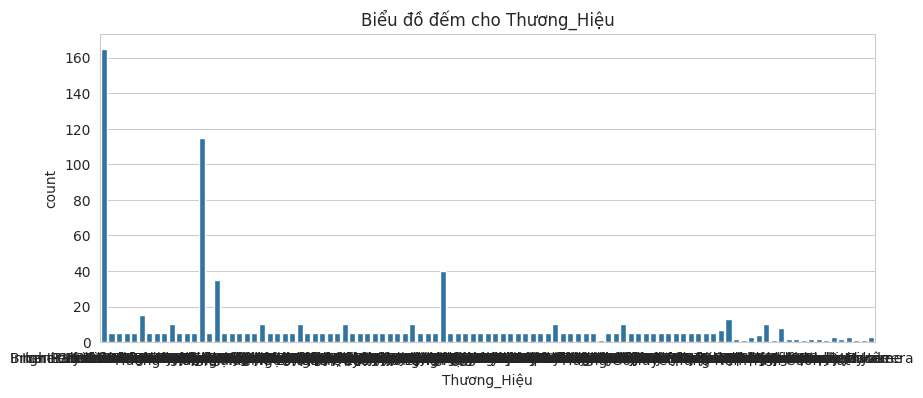

In [13]:
# Vẽ biểu đồ đếm cho các cột phân loại
for col in cat_cols:
    plt.figure(figsize=[10, 4])
    sns.countplot(x=col, data=df_main)
    plt.title(f'Biểu đồ đếm cho {col}')
    plt.show()

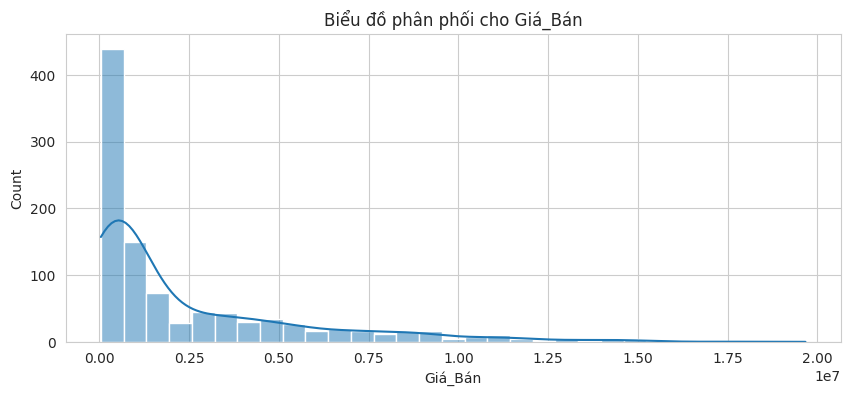

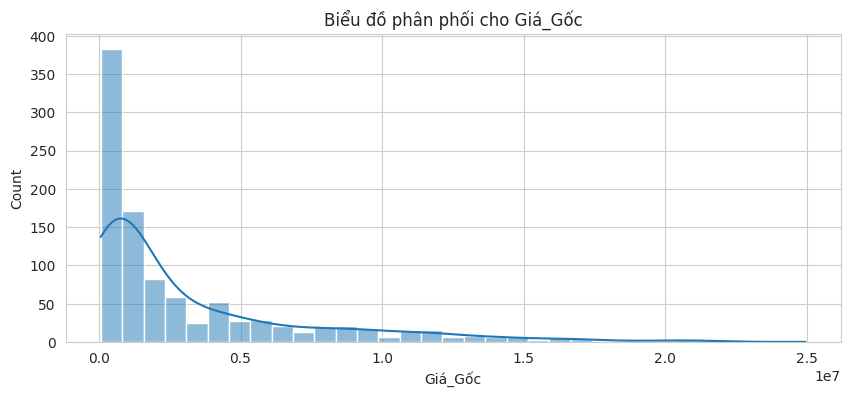

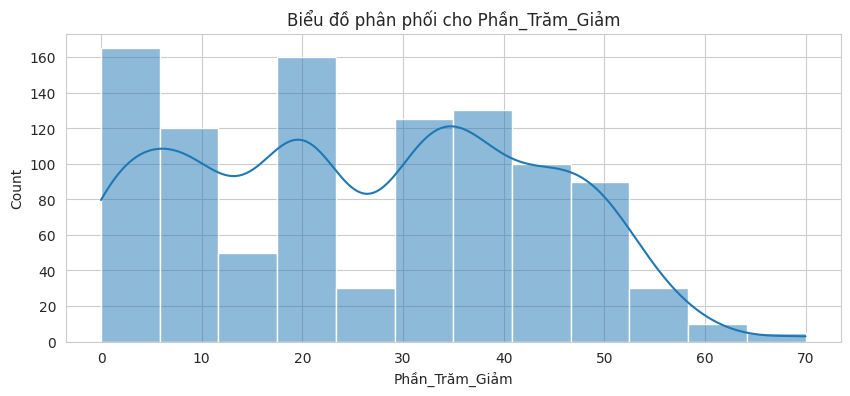

In [14]:
# Nếu bạn có các cột số liệu muốn phân tích, bạn có thể vẽ biểu đồ phân phối
num_cols = ['Giá_Bán', 'Giá_Gốc', 'Phần_Trăm_Giảm']
for col in num_cols:
    plt.figure(figsize=[10, 4])
    sns.histplot(df_main[col], kde=True)
    plt.title(f'Biểu đồ phân phối cho {col}')
    plt.show()

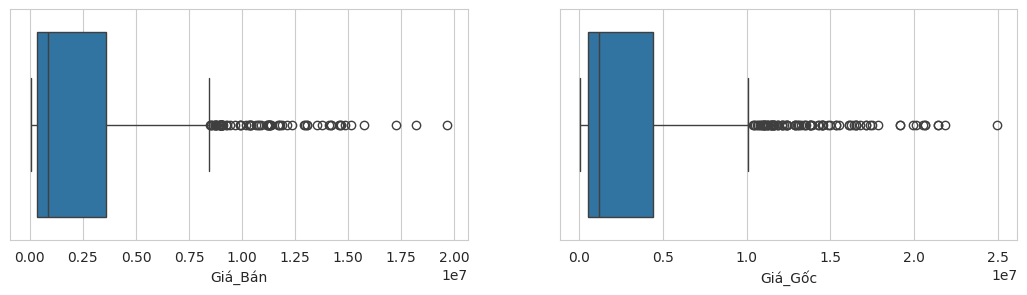

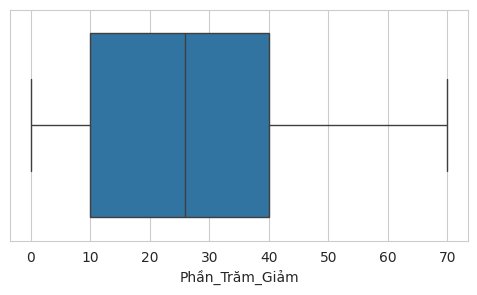

In [15]:
# Định nghĩa các cột số liệu để phân tích
num_cols = ['Giá_Bán', 'Giá_Gốc', 'Phần_Trăm_Giảm']
i = 0
while i < len(num_cols):
    fig = plt.figure(figsize=[13, 3])
    
    # Vẽ biểu đồ boxplot cho từng cột
    plt.subplot(1, 2, 1)
    sns.boxplot(x=num_cols[i], data=df_main)
    i += 1
    
    if i < len(num_cols):  # Kiểm tra để tránh vượt quá danh sách các cột
        plt.subplot(1, 2, 2)
        sns.boxplot(x=num_cols[i], data=df_main)
        i += 1
    
    plt.show()

In [16]:
# Hiển thị các hàng có giá bán cao hơn ngưỡng 99%
print(df_main[df_main['Giá_Bán'] > df_main['Giá_Bán'].quantile(0.99)])


     sothutu                                       Tên_Sản_Phẩm  \
748      748  Nước Hoa Nữ Narciso Rodriguez Pure Musc For He...   
751      751  Nước Hoa Nữ Carolina Herrera Very Good Girl Gl...   
856      856  Nước Hoa Nam Paco Rabanne 1 Million Parfum EDP...   
932      932    Nước Hoa Nữ Narciso Rodriguez For Her EDP 500ml   
936      936  Nước Hoa Nữ Narciso Rodriguez Pure Musc For He...   
939      939  Nước Hoa Nữ Carolina Herrera Very Good Girl Gl...   
948      948  Nước Hoa Nữ Issey Miyake A Drop D'Issey EDP 450ml   
969      969      Nước Hoa Nữ Chloé L'Eau Eau De Toilette 500ml   
970      970                 Nước Hoa Nữ Chloé Nomade EDP 375ml   
977      977                 Nước Hoa Nữ Burberry Her EDP 500ml   
990      990              Nước Hoa Nữ Chloé Eau De Parfum 375ml   

                           Thương_Hiệu   Giá_Bán   Giá_Gốc  Phần_Trăm_Giảm  
748                      Eau De Parfum  14548000  15320000               5  
751  Very Good Girl Glam Eau De Parfum  1

In [17]:

# Hiển thị các hàng có giá gốc cao hơn ngưỡng 99%
print(df_main[df_main['Giá_Gốc'] > df_main['Giá_Gốc'].quantile(0.99)])


     sothutu                                       Tên_Sản_Phẩm  \
789      789                 Nước Hoa Nữ Burberry Her EDP 400ml   
932      932    Nước Hoa Nữ Narciso Rodriguez For Her EDP 500ml   
936      936  Nước Hoa Nữ Narciso Rodriguez Pure Musc For He...   
939      939  Nước Hoa Nữ Carolina Herrera Very Good Girl Gl...   
966      966         Nước Hoa Nữ Burberry Her Blossom EDT 500ml   
968      968          Nước Hoa Nữ Marc Jacobs Perfect EDP 500ml   
969      969      Nước Hoa Nữ Chloé L'Eau Eau De Toilette 500ml   
970      970                 Nước Hoa Nữ Chloé Nomade EDP 375ml   
974      974  [HSD 03/2025] Nước Hoa Nữ Chloé L'Eau Eau De T...   
977      977                 Nước Hoa Nữ Burberry Her EDP 500ml   
990      990              Nước Hoa Nữ Chloé Eau De Parfum 375ml   

                           Thương_Hiệu   Giá_Bán   Giá_Gốc  Phần_Trăm_Giảm  
789                  Her Eau De Parfum  11868000  19960000              41  
932                      Eau De Parfum  1

In [18]:
# Hiển thị các hàng có phần trăm giảm giá cao hơn ngưỡng 99%
print(df_main[df_main['Phần_Trăm_Giảm'] > df_main['Phần_Trăm_Giảm'].quantile(0.99)])


      sothutu                                       Tên_Sản_Phẩm  \
181       181  [HSD 07/2024] Nước Hoa Nữ Trussardi Sound Of D...   
441       441  [HSD 07/2024] Nước Hoa Nữ Trussardi Sound Of D...   
629       629  [HSD 07/2024] Nước Hoa Nữ Trussardi Sound Of D...   
817       817  [HSD 07/2024] Nước Hoa Nữ Trussardi Sound Of D...   
1005     1005  [HSD 07/2024] Nước Hoa Nữ Trussardi Sound Of D...   

                             Thương_Hiệu  Giá_Bán   Giá_Gốc  Phần_Trăm_Giảm  
181   Sound Of Donna Eau De Parfum Spray   726000   2420000              70  
441   Sound Of Donna Eau De Parfum Spray  1452000   4840000              70  
629   Sound Of Donna Eau De Parfum Spray  2178000   7260000              70  
817   Sound Of Donna Eau De Parfum Spray  2904000   9680000              70  
1005  Sound Of Donna Eau De Parfum Spray  3630000  12100000              70  


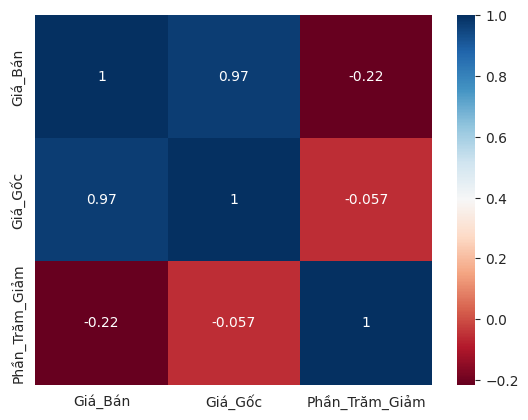

Giá_Bán           1.000000
Giá_Gốc           0.966827
Phần_Trăm_Giảm   -0.215111
Name: Giá_Bán, dtype: float64


In [19]:
# Lọc các cột số liệu
numeric_df = df_main[['Giá_Bán', 'Giá_Gốc', 'Phần_Trăm_Giảm']]

# Vẽ biểu đồ heatmap để hiển thị tương quan giữa các biến
sns.heatmap(numeric_df.corr(), annot=True, cmap="RdBu")
plt.show()

# Hiển thị tương quan của cột 'Giá_Bán' với các cột khác
print(numeric_df.corr()['Giá_Bán'])


In [20]:
# Thay thế NaN trong cột 'Thương_Hiệu' bằng 'Elite Perfume'
df_main['Thương_Hiệu'].fillna('Elite Perfume', inplace=True)
df_main['Phần_Trăm_Giảm'] = df_main['Phần_Trăm_Giảm'].fillna(0.0)
df_main.loc[df_main['Phần_Trăm_Giảm'] == 0.0, 'Giá_Gốc'] = df_main['Giá_Bán']

df_main = df_main.drop(columns=['Tên_Sản_Phẩm'])  # Loại bỏ các cột không cần thiết
X = df_main.drop(columns=['Giá_Bán'])  # Biến đầu vào
y = df_main['Giá_Bán']  # Biến mục tiêu




/tmp/ipykernel_15043/2222221262.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_main['Thương_Hiệu'].fillna('Elite Perfume', inplace=True)


In [21]:
df_main.head()


,sothutu,Thương_Hiệu,Giá_Bán,Giá_Gốc,Phần_Trăm_Giảm
0,0,Eau De Parfum,301000,549000,45
1,1,Inner Perfume #Eau De Bijou,144000,350000,59
2,2,Eau De Parfum,275000,549000,50
3,3,Eau De Parfum,275000,549000,50
4,4,Eau De Parfum,301000,549000,45


In [22]:
# Chuyển đổi các biến phân loại thành biến số (One-Hot Encoding)
X = pd.get_dummies(X, drop_first=True)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

CV = []
R2_train = []
R2_test = []

In [23]:
# Phân chia dữ liệu thành tập huấn luyện và tập kiểm tra

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (812, 106)
X_test shape: (203, 106)
y_train shape: (812,)
y_test shape: (203,)


In [24]:
def perfume_pred_model(model, model_name):
    # Huấn luyện mô hình
    model.fit(X_train, y_train)
            
    # R2 score của tập huấn luyện
    y_pred_train = model.predict(X_train)
    R2_train_model = r2_score(y_train, y_pred_train)
    R2_train.append(round(R2_train_model, 2))
    
    # R2 score của tập kiểm tra
    y_pred_test = model.predict(X_test)
    R2_test_model = r2_score(y_test, y_pred_test)
    R2_test.append(round(R2_test_model, 2))
    
    # R2 mean của tập huấn luyện sử dụng Cross validation
    cross_val = cross_val_score(model, X_train, y_train, cv=5)
    cv_mean = cross_val.mean()
    CV.append(round(cv_mean, 2))
    
    # In kết quả
    print("Train R2-score:", round(R2_train_model, 2))
    print("Test R2-score:", round(R2_test_model, 2))
    print("Train CV scores:", cross_val)
    print("Train CV mean:", round(cv_mean, 2))
    
    # Vẽ đồ thị
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    
    # Residual Plot của dữ liệu huấn luyện
    ax[0].set_title('Residual Plot of Train samples')
    sns.distplot((y_train - y_pred_train), hist=False, ax=ax[0])
    ax[0].set_xlabel('y_train - y_pred_train')
    
    # Đồ thị scatter giữa y_test và y_pred_test
    ax[1].set_title('y_test vs y_pred_test')
    ax[1].scatter(x=y_test, y=y_pred_test)
    ax[1].set_xlabel('y_test')
    ax[1].set_ylabel('y_pred_test')
    
    plt.show()



Train R2-score: 0.98
Test R2-score: 0.97
Train CV scores: [0.96202141 0.9736886  0.96737925 0.96601431 0.97551083]
Train CV mean: 0.97


/tmp/ipykernel_15043/850750115.py:31: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_train - y_pred_train), hist=False, ax=ax[0])


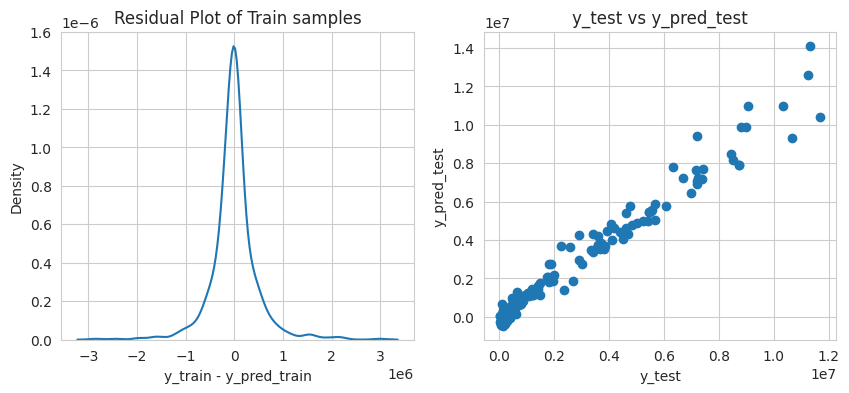

Mean Absolute Error: 298916.0904335855
Mean Squared Error: 246009628723.44797
Root Mean Squared Error: 495993.5773006017
     Giá_Ban_Dau   Gia_Du_Doan
752      4640000  5.398811e+06
519       162000  6.900853e+04
210      4075000  4.841585e+06
611       609000  1.290878e+05
914      1155000  1.198538e+06
..           ...           ...
370      3600000  3.749506e+06
381      1978000  1.857726e+06
780     10356000  1.100333e+07
760     11700000  1.042287e+07
682       716000  6.708049e+05

[203 rows x 2 columns]


In [25]:
# Khởi tạo mô hình Linear Regression
linear_reg = LinearRegression()
perfume_pred_model(linear_reg, "linear.pkl")
# Huấn luyện mô hình
linear_reg.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
y_pred_test = linear_reg.predict(X_test)

# Kiểm thử mô hình
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

# So sánh giá ban đầu với giá mô hình dự đoán
comparison_df = pd.DataFrame({'Giá_Ban_Dau': y_test, 'Gia_Du_Doan': y_pred_test})
print(comparison_df)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=8.43328e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=7.9308e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=8.31819e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=8.05741e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/codespace/.local/lib/python3.10/sit

[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s[CV] END ..........................................alpha=0.1; total time=   0.0s

[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ...........................................alpha=10; total time=   0.0s
[CV] END ...........................................alpha=10; total time=   0.0s
[CV] END ...................

/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=6.59232e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=6.59232e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=8.43328e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/codespace/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=8.50138e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/codespace/.local/lib/python3.10/si

Best parameters for Ridge Regression: {'alpha': 1}
Train R2-score: 0.98
Test R2-score: 0.97
Train CV scores: [0.97588079 0.97274116 0.97240536 0.96875305 0.97340595]
Train CV mean: 0.97


/tmp/ipykernel_15043/850750115.py:31: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_train - y_pred_train), hist=False, ax=ax[0])


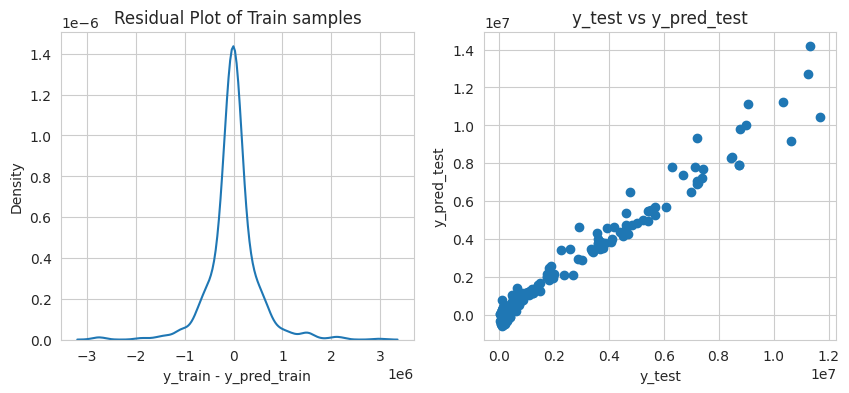

Mean Absolute Error: 311460.77540538873
Mean Squared Error: 261373479781.5251
Root Mean Squared Error: 511246.9851075164
     Giá_Ban_Dau   Gia_Du_Doan
752      4640000  5.356270e+06
519       162000  6.980291e+04
210      4075000  3.842878e+06
611       609000  2.149067e+05
914      1155000  1.237102e+06
..           ...           ...
370      3600000  3.769851e+06
381      1978000  1.927598e+06
780     10356000  1.121376e+07
760     11700000  1.044035e+07
682       716000  7.123802e+05

[203 rows x 2 columns]


In [26]:
# Khởi tạo mô hình Ridge Regression
ridge_reg = Ridge()
# Thiết lập các tham số cần tìm kiếm
param_grid_ridge = {'alpha': [0.1, 1, 10, 100]}

# Grid search với cross-validation
grid_search_ridge = GridSearchCV(estimator=ridge_reg, param_grid=param_grid_ridge, cv=5, n_jobs=-1, verbose=2)
grid_search_ridge.fit(X_train, y_train)

# In ra các tham số tốt nhất
print(f"Best parameters for Ridge Regression: {grid_search_ridge.best_params_}")

# Sử dụng mô hình tốt nhất để dự đoán
best_ridge = grid_search_ridge.best_estimator_
y_pred_test = best_ridge.predict(X_test)
perfume_pred_model(ridge_reg, "ridge.pkl")
# Kiểm thử mô hình
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

# So sánh giá ban đầu với giá mô hình dự đoán
comparison_df = pd.DataFrame({'Giá_Ban_Dau': y_test, 'Gia_Du_Doan': y_pred_test})
print(comparison_df)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.8s


[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.1s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estim

/tmp/ipykernel_15043/850750115.py:31: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((y_train - y_pred_train), hist=False, ax=ax[0])


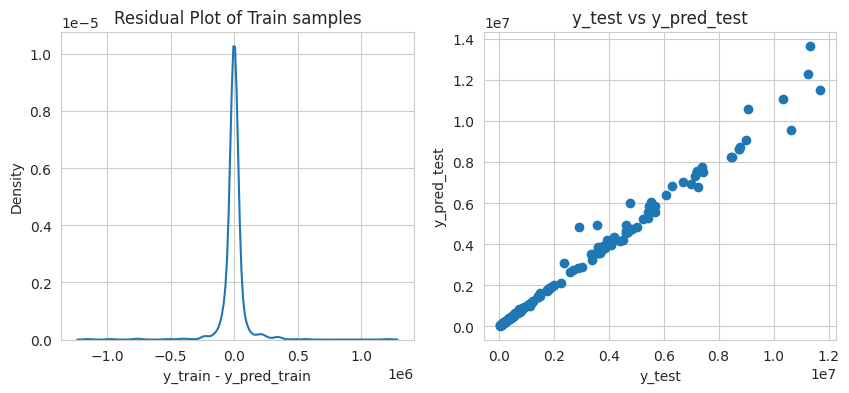

Mean Absolute Error: 311460.77540538873
Mean Squared Error: 261373479781.5251
Root Mean Squared Error: 511246.9851075164
     Giá_Ban_Dau   Gia_Du_Doan
752      4640000  4.919830e+06
519       162000  1.554471e+05
210      4075000  3.991259e+06
611       609000  6.117004e+05
914      1155000  1.147830e+06
..           ...           ...
370      3600000  3.748898e+06
381      1978000  1.990215e+06
780     10356000  1.106900e+07
760     11700000  1.150410e+07
682       716000  7.190641e+05

[203 rows x 2 columns]


In [27]:
# Khởi tạo mô hình Random Forest
rf = RandomForestRegressor(random_state=42)

# Thiết lập các tham số cần tìm kiếm
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid search với cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Huấn luyện mô hình
grid_search.fit(X_train, y_train)

# In ra các tham số tốt nhất
print(f"Best parameters: {grid_search.best_params_}")

# Sử dụng mô hình tốt nhất để dự đoán
best_rf = grid_search.best_estimator_
perfume_pred_model(best_rf, "RandomForest_regressor.pkl")

# Kiểm thử mô hình
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

# So sánh giá ban đầu với giá mô hình dự đoán
y_pred_test = best_rf.predict(X_test)
comparison_df = pd.DataFrame({'Giá_Ban_Dau': y_test, 'Gia_Du_Doan': y_pred_test})
print(comparison_df)


In [28]:
# Khởi tạo mô hình Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state=42)
# Thiết lập các tham số cần tìm kiếm
param_grid_gbr = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.05],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid search với cross-validation
grid_search_gbr = GridSearchCV(estimator=gbr, param_grid=param_grid_gbr, cv=5, n_jobs=-1, verbose=2)
grid_search_gbr.fit(X_train, y_train)

# In ra các tham số tốt nhất
print(f"Best parameters for Gradient Boosting Regressor: {grid_search_gbr.best_params_}")

# Sử dụng mô hình tốt nhất để dự đoán
best_gbr = grid_search_gbr.best_estimator_
y_pred_test = best_gbr.predict(X_test)
perfume_pred_model(gbr, "gbr.pkl")
# Kiểm thử mô hình
mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

# So sánh giá ban đầu với giá mô hình dự đoán
comparison_df = pd.DataFrame({'Giá_Ban_Dau': y_test, 'Gia_Du_Doan': y_pred_test})
print(comparison_df)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END learning_rate=0.01, max_depth=3

In [ ]:
# Tổng hợp kết quả
Technique = ["Linear Regression", "Ridge Regression", "Random Forest", "Gradient Boosting"]
results = pd.DataFrame({
    'Model': Technique,
    'R Squared(Train)': R2_train,
    'R Squared(Test)': R2_test,
    'CV score mean(Train)': CV
})
display(results)

,Model,R Squared(Train),R Squared(Test),CV score mean(Train)
0,Linear Regression,0.99,0.95,0.96
1,Ridge Regression,0.98,0.96,0.97
2,Random Forest,1.00,0.97,0.99
3,Gradient Boosting,1.00,0.98,0.99
